In [1]:
import common_functions
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pickle
import glob
import time
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.ndimage.measurements import label
from sklearn.utils import shuffle
from sklearn.svm import LinearSVC
%matplotlib inline

In [2]:
# Read in car and non-car images
cars = glob.glob('../data/vehicles/*/*.png')
notcars = glob.glob('../data/non-vehicles/*/*.png')

In [19]:
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 2 # Can be 0, 1, 2, or "ALL"

t=time.time()
car_features = []
notcar_features = []
for car_image in cars:
    image = mpimg.imread(car_image)
    car_features.append(common_functions.extract_hog_features(image, color_space=colorspace, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel))
for notcar_image in notcars:
    image = mpimg.imread(notcar_image)
    notcar_features.append(common_functions.extract_hog_features(image, color_space=colorspace, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel))

t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC(C=1.0)
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

29.03 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 1764
17.15 Seconds to train SVC...
Test Accuracy of SVC =  0.9105
My SVC predicts:  [ 0.  1.  0.  0.  0.  0.  1.  1.  1.  0.]
For these 10 labels:  [ 0.  1.  0.  0.  0.  0.  1.  0.  1.  0.]
0.00199 Seconds to predict 10 labels with SVC


In [2]:
# Load the classifier and parameters
data_file = 'classifier_model.p'
with open(data_file, mode='rb') as f:
    data = pickle.load(f)
    
svc = data['svc'] 
X_scaler = data['X_scaler']
colorspace = data['colorspace']
spatial = data['spatial']
histbin = data['histbin']
orient = data['orient']
pix_per_cell = data['pix_per_cell']
cell_per_block = data ['cell_per_block']
hog_channel = data['hog_channel']
spatial_feat = data ['spatial_feat']
hist_feat = data['hist_feat']
hog_feat = data['hog_feat']

In [3]:
test_pro_imgs = glob.glob('./cache/*.png')
test_pro_features = []
for test_pro_image in test_pro_imgs:
    image = mpimg.imread(test_pro_image)
    test_pro_features.append(
        common_functions.combine_img_features(
            image, color_space=colorspace, spatial_size=(spatial, spatial), hist_bins=histbin, orient=orient, 
            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel, 
            spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat
        )
    )

result_feat = X_scaler.transform(test_pro_features)

print('My SVC predicts: ', svc.predict(result_feat))

My SVC predicts:  [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  0.  1.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


In [12]:
test_pro_imgs = glob.glob('./cache/*.png')
test_pro_features = []
for test_pro_image in test_pro_imgs:
    image = mpimg.imread(test_pro_image)
    single_feature = common_functions.combine_img_features(
        image, color_space=colorspace, spatial_size=(spatial, spatial), hist_bins=histbin, orient=orient,
        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat
    )
    test_pro_features.append(single_feature)
    result_feat = X_scaler.transform(np.array(single_feature).reshape(1, -1))
    prediction = svc.predict(result_feat)

result_feat = X_scaler.transform(test_pro_features)

print('My SVC predicts: ', svc.predict(result_feat))

My SVC predicts:  [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  0.  1.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


In [24]:
image = mpimg.imread('./cache/image-40.png')
single_feature = common_functions.combine_img_features(
    image, color_space=colorspace, spatial_size=(spatial, spatial), hist_bins=histbin, orient=orient,
    pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
    spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat
)

result_feat = X_scaler.transform(np.array(single_feature).reshape(1, -1))

print('My SVC predicts: ', svc.predict(result_feat) == 1)

My SVC predicts:  [ True]


0.37039  Seconds to search windows ...


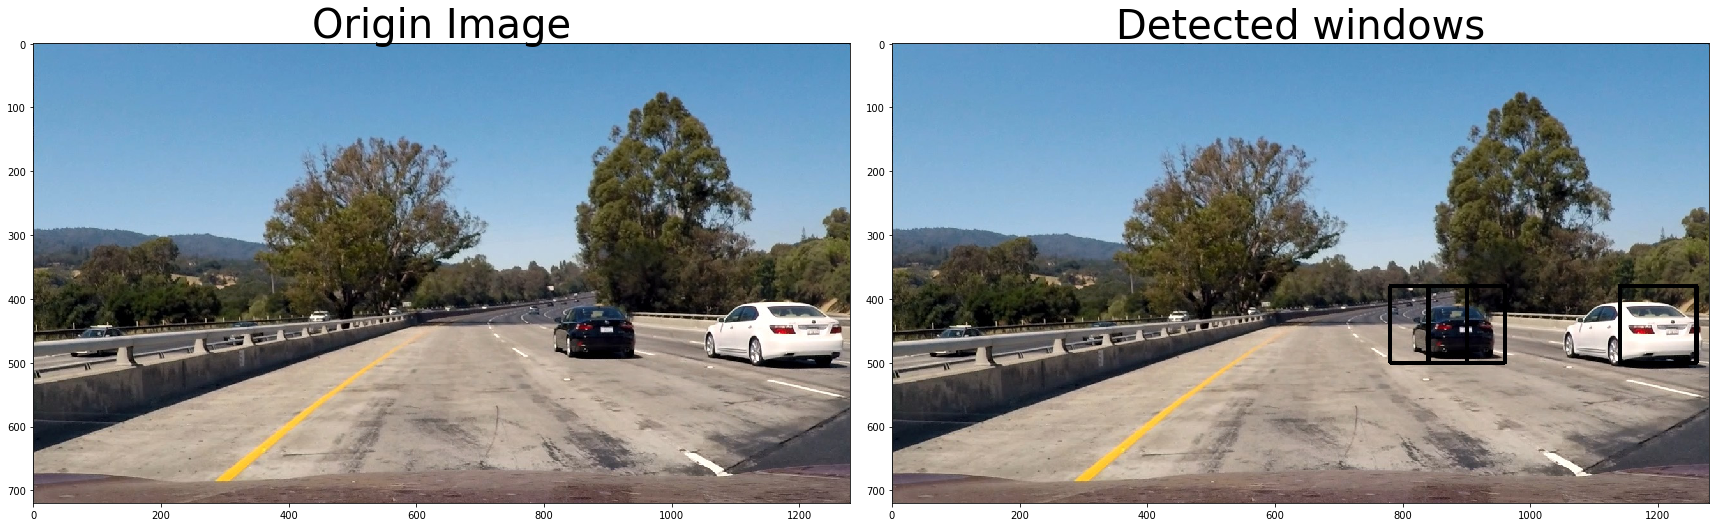

In [8]:
image = mpimg.imread('./test_images/test1.jpg')
image = image.astype(np.float32)/255
draw_image = np.copy(image)

t=time.time()
windows = common_functions.slide_window(
    image, x_start_stop=[None, None], y_start_stop=[320, 720],
    xy_window=(120, 120), xy_overlap=(0.5, 0.5)
)

cut_images = []
detected_windows = []
num = 1
for window in windows:
    test_img = cv2.resize(image[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
    #test_img = image[window[0][1]:window[1][1], window[0][0]:window[1][0]]
    #test_img = test_img.resize((64, 64))
    #plt.imsave('./cache/image-' + str(num) + '.png', test_img)
    #num += 1
    cut_images.append(test_img)
    features = common_functions.combine_img_features(
        test_img, color_space=colorspace, spatial_size=(spatial, spatial), hist_bins=histbin,
        orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat
    )
    
    test_features = X_scaler.transform(np.array(features).reshape(1, -1))
    
    prediction = svc.predict(test_features)
    
    if prediction == 1:
        detected_windows.append(window)

#detected_windows =  common_functions.search_windows(
#    image, windows, clf=svc, scaler=X_scaler, color_space=colorspace,
#    spatial_size=(spatial, spatial), hist_bins=histbin, orient=orient,
#    pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
#    spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat
#)
t2 = time.time()
print(round(t2-t, 5), ' Seconds to search windows ...')

window_img = common_functions.draw_boxes(draw_image, detected_windows, color=(0, 0, 255), thick=6)                    

plt.figure()
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Origin Image', fontsize=40)

ax2.imshow(window_img)
ax2.set_title('Detected windows', fontsize=40)

plt.show()

In [9]:
for cut_img in cut_images:
    single_feature = common_functions.combine_img_features(
        np.copy(cut_img), color_space=colorspace, spatial_size=(spatial, spatial), hist_bins=histbin, orient=orient,
        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat
    )
    result_feat = X_scaler.transform(np.array(single_feature).reshape(1, -1))
    prediction = svc.predict(result_feat)
    print(' predicts: ', svc.predict(result_feat))

 predicts:  [ 0.]
 predicts:  [ 0.]
 predicts:  [ 0.]
 predicts:  [ 0.]
 predicts:  [ 0.]
 predicts:  [ 0.]
 predicts:  [ 0.]
 predicts:  [ 0.]
 predicts:  [ 0.]
 predicts:  [ 0.]
 predicts:  [ 0.]
 predicts:  [ 0.]
 predicts:  [ 0.]
 predicts:  [ 0.]
 predicts:  [ 0.]
 predicts:  [ 0.]
 predicts:  [ 0.]
 predicts:  [ 0.]
 predicts:  [ 0.]
 predicts:  [ 0.]
 predicts:  [ 0.]
 predicts:  [ 0.]
 predicts:  [ 0.]
 predicts:  [ 0.]
 predicts:  [ 0.]
 predicts:  [ 0.]
 predicts:  [ 0.]
 predicts:  [ 0.]
 predicts:  [ 0.]
 predicts:  [ 0.]
 predicts:  [ 0.]
 predicts:  [ 0.]
 predicts:  [ 0.]
 predicts:  [ 1.]
 predicts:  [ 1.]
 predicts:  [ 0.]
 predicts:  [ 0.]
 predicts:  [ 0.]
 predicts:  [ 0.]
 predicts:  [ 1.]
 predicts:  [ 0.]
 predicts:  [ 0.]
 predicts:  [ 0.]
 predicts:  [ 0.]
 predicts:  [ 0.]
 predicts:  [ 0.]
 predicts:  [ 0.]
 predicts:  [ 0.]
 predicts:  [ 0.]
 predicts:  [ 0.]
 predicts:  [ 0.]
 predicts:  [ 0.]
 predicts:  [ 0.]
 predicts:  [ 0.]
 predicts:  [ 0.]
 predicts:

0.38263  Seconds to search windows ...


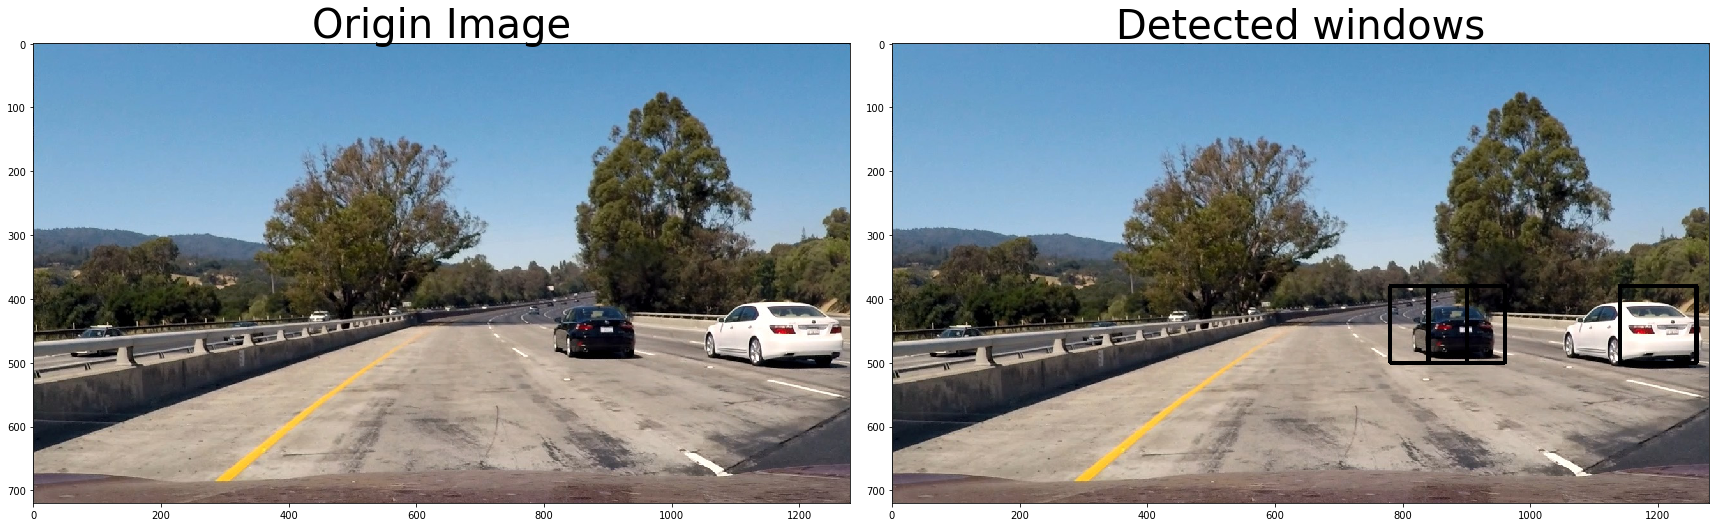

In [10]:
image = mpimg.imread('./test_images/test1.jpg')
image = image.astype(np.float32)/255
draw_image = np.copy(image)

t=time.time()
windows = common_functions.slide_window(
    image, x_start_stop=[None, None], y_start_stop=[320, 720],
    xy_window=(120, 120), xy_overlap=(0.5, 0.5)
)

detected_windows =  common_functions.search_windows(
    image, windows, clf=svc, scaler=X_scaler, color_space=colorspace,
    spatial_size=(spatial, spatial), hist_bins=histbin, orient=orient,
    pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
    spatial_feat=True, hist_feat=True, hog_feat=True
)
t2 = time.time()
print(round(t2-t, 5), ' Seconds to search windows ...')

window_img = common_functions.draw_boxes(draw_image, detected_windows, color=(0, 0, 255), thick=6)                    

plt.figure()
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Origin Image', fontsize=40)

ax2.imshow(window_img)
ax2.set_title('Detected windows', fontsize=40)

plt.show()